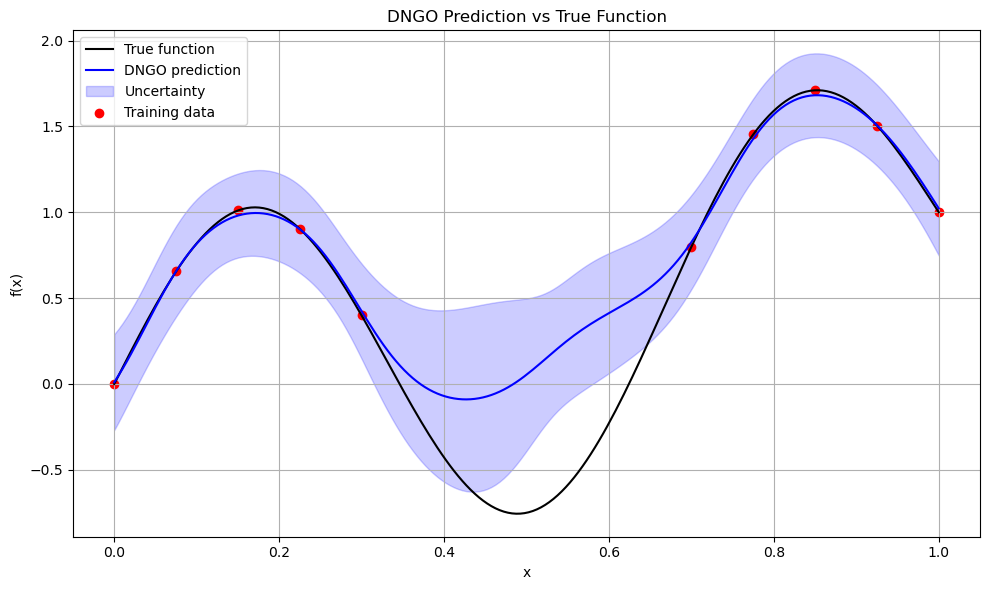

In [21]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# 1. Define dummy function: f(x) = sin(3πx) + x^2
def dummy_function(x):
    return np.sin(3 * np.pi * x) + x ** 2

# 2. Generate training data (few points)
np.random.seed(0)
# (0~0.3)과 (0.7~1.0)에서만 샘플 10개
X_train_left = np.linspace(0.0, 0.3, 5).reshape(-1, 1)
X_train_right = np.linspace(0.7, 1.0, 5).reshape(-1, 1)
X_train = np.vstack([X_train_left, X_train_right])
y_train = dummy_function(X_train).ravel()
# 3. Define DNGO basis network (feature extractor)
class DNGONet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[50, 50], output_dim=50):
        super(DNGONet, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.Tanh())
        self.feature_net = nn.Sequential(*layers)

    def forward(self, x):
        return self.feature_net(x)

# 4. Train DNN (as feature extractor)
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

model = DNGONet(input_dim=1)
# DNN + 임시 선형층을 같이 학습
out_layer = nn.Linear(model.feature_net[-2].out_features, 1, bias=False)
optimizer = torch.optim.Adam(list(model.parameters()) + list(out_layer.parameters()), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(1500):
    optimizer.zero_grad()
    features = model(X_tensor)
    temp_pred = out_layer(features)
    loss = loss_fn(temp_pred, y_tensor)
    loss.backward()
    optimizer.step()

# 5. Extract basis features
with torch.no_grad():
    Phi_train = model(X_tensor).numpy()

# 6. Bayesian Linear Regression on last layer
class BayesianLinearRegression:
    def __init__(self, alpha=1, beta=25.0):
        self.alpha = alpha
        self.beta = beta

    def fit(self, Phi, y):
        I = np.eye(Phi.shape[1])
        self.K = self.beta * Phi.T @ Phi + self.alpha * I
        self.K_inv = np.linalg.inv(self.K)
        self.m = self.beta * self.K_inv @ Phi.T @ y

    def predict(self, phi_x):
        mean = phi_x @ self.m
        var = phi_x @ self.K_inv @ phi_x.T + 1 / self.beta
        return mean, var

blr = BayesianLinearRegression()
blr.fit(Phi_train, y_train)

# 7. Predict over test inputs
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
with torch.no_grad():
    Phi_test = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

y_pred = []
y_std = []

for phi in Phi_test:
    mu, var = blr.predict(phi)
    y_pred.append(mu)
    y_std.append(np.sqrt(var))

y_pred = np.array(y_pred)
y_std = np.array(y_std)
y_true = dummy_function(X_test)

# 8. Plotting
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True function', color='black')
plt.plot(X_test, y_pred, label='DNGO prediction', color='blue')
plt.fill_between(X_test.ravel(), y_pred - y_std, y_pred + y_std, color='blue', alpha=0.2, label='Uncertainty')
plt.scatter(X_train, y_train, color='red', label='Training data')
plt.legend()
plt.title("DNGO Prediction vs True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()
plt.show()


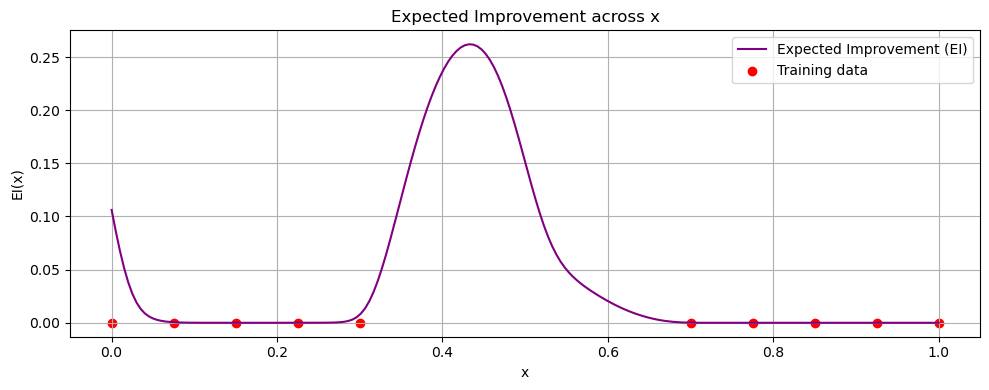

In [26]:
from scipy.stats import norm

def expected_improvement(mu, sigma, y_best):
    # sigma==0일 때 EI=0으로 처리
    sigma = np.maximum(sigma, 1e-8)
    z = (y_best - mu) / sigma
    ei = (y_best - mu) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei

# 1. 현재까지 관측된 최적값
y_best = np.min(y_train)  # 최소화 기준

# 2. EI 계산
ei = expected_improvement(y_pred, y_std, y_best)

# 3. EI 플롯
plt.figure(figsize=(10, 4))
plt.plot(X_test, ei, label='Expected Improvement (EI)', color='purple')
plt.scatter(X_train, np.zeros_like(X_train), color='red', label='Training data')
plt.title("Expected Improvement across x")
plt.xlabel("x")
plt.ylabel("EI(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


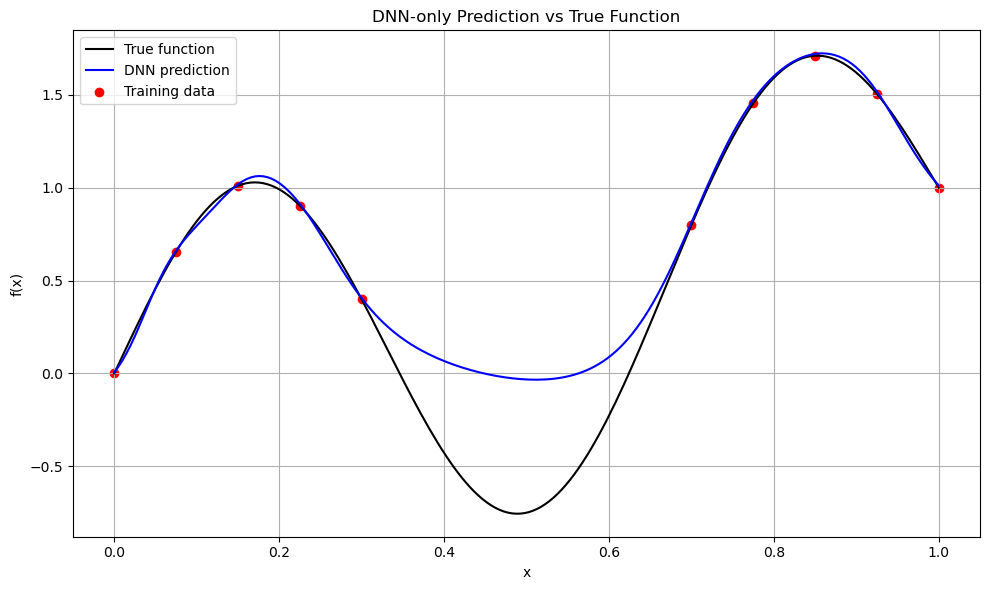

In [14]:
# 1. 테스트 데이터 생성
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 2. DNN+임시 선형층 예측값 계산
with torch.no_grad():
    features_test = model(X_test_tensor)
    y_dnn_pred = out_layer(features_test).numpy().ravel()

y_true = dummy_function(X_test)

# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True function', color='black')
plt.plot(X_test, y_dnn_pred, label='DNN prediction', color='blue')
plt.scatter(X_train, y_train, color='red', label='Training data')
plt.legend()
plt.title("DNN-only Prediction vs True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()
plt.show()


## GPR 

/software/spackages_v0_21_prod/apps/linux-ubuntu22.04-zen2/gcc-13.2.0/anaconda3-2022.10-5wy43yh5crcsmws4afls5thwoskzarhe/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


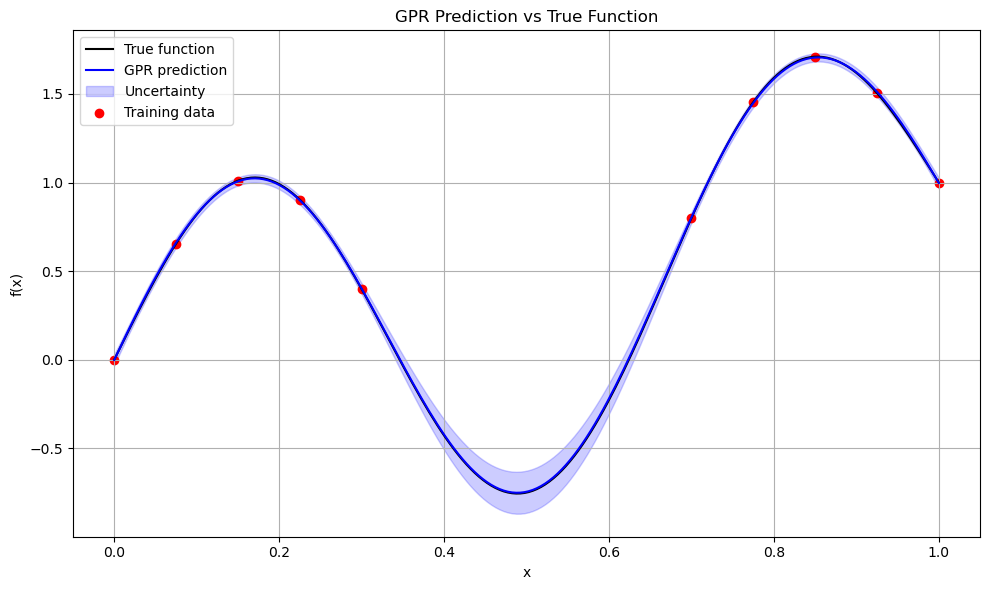

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# 1. 데이터 (위에서와 동일하게!)
def dummy_function(x):
    return np.sin(3 * np.pi * x) + x ** 2

# 2. Generate training data (few points)
np.random.seed(0)
# (0~0.3)과 (0.7~1.0)에서만 샘플 10개
X_train_left = np.linspace(0.0, 0.3, 5).reshape(-1, 1)
X_train_right = np.linspace(0.7, 1.0, 5).reshape(-1, 1)
X_train = np.vstack([X_train_left, X_train_right])
y_train = dummy_function(X_train).ravel()

# 2. GPR 커널 정의 (RBF + 상수항)
kernel = C(1.0, (1e1, 1e2)) * RBF(length_scale=0.2, length_scale_bounds=(1e-2, 100))

# 3. GPR 모델 학습
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-3)
gpr.fit(X_train, y_train)

# 4. 테스트 및 예측
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = dummy_function(X_test)
y_pred, y_std = gpr.predict(X_test, return_std=True)

# 5. 시각화
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True function', color='black')
plt.plot(X_test, y_pred, label='GPR prediction', color='blue')
plt.fill_between(X_test.ravel(), y_pred - y_std, y_pred + y_std, color='blue', alpha=0.2, label='Uncertainty')
plt.scatter(X_train, y_train, color='red', label='Training data')
plt.legend()
plt.title("GPR Prediction vs True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.tight_layout()
plt.show()


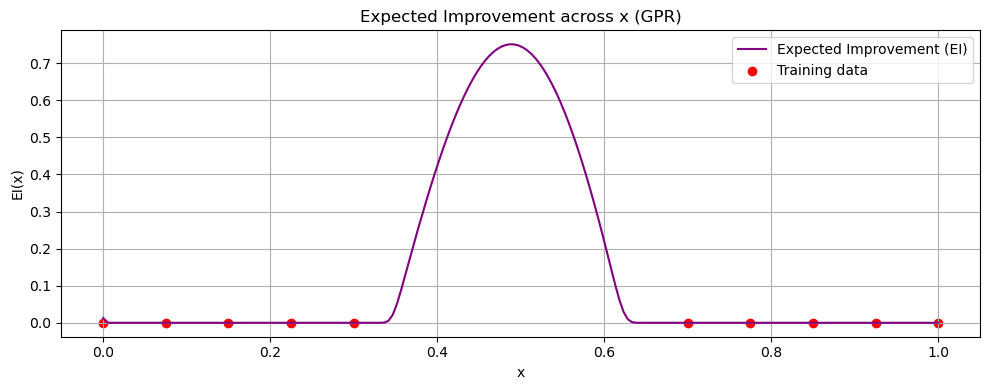

In [20]:
from scipy.stats import norm

def expected_improvement(mu, sigma, y_best):
    sigma = np.maximum(sigma, 1e-8)
    z = (y_best - mu) / sigma
    ei = (y_best - mu) * norm.cdf(z) + sigma * norm.pdf(z)
    return ei

# 1. 관측 최적값
y_best = np.min(y_train)  # 최소화 기준

# 2. EI 계산
ei = expected_improvement(y_pred, y_std, y_best)

# 3. EI 시각화
plt.figure(figsize=(10, 4))
plt.plot(X_test, ei, label='Expected Improvement (EI)', color='purple')
plt.scatter(X_train, np.zeros_like(X_train), color='red', label='Training data')
plt.title("Expected Improvement across x (GPR)")
plt.xlabel("x")
plt.ylabel("EI(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
y_std

array([0.00099922, 0.00095379, 0.00103107, 0.00114654, 0.00125348,
       0.00133372, 0.00138243, 0.00140052, 0.00139146, 0.00135977,
       0.0013105 , 0.00124884, 0.00118002, 0.0011092 , 0.0010413 ,
       0.00098082, 0.00093152, 0.00089592, 0.00087493, 0.00086772,
       0.00087196, 0.00088441, 0.00090159, 0.00092026, 0.00093775,
       0.00095202, 0.0009617 , 0.00096598, 0.00096463, 0.00095783,
       0.00094621, 0.00093072, 0.00091265, 0.0008935 , 0.00087494,
       0.0008587 , 0.00084639, 0.00083934, 0.00083843, 0.00084397,
       0.0008556 , 0.00087241, 0.000893  , 0.00091571, 0.00093871,
       0.00096023, 0.00097859, 0.00099231, 0.00100018, 0.00100133,
       0.00099525, 0.00098197, 0.00096217, 0.00093736, 0.00091021,
       0.00088486, 0.00086718, 0.00086462, 0.00088538, 0.0009366 ,
       0.00102255, 0.00114403, 0.00129916, 0.00148481, 0.00169762,
       0.00193449, 0.00219269, 0.00246986, 0.0027639 , 0.00307289,
       0.00339502, 0.00372856, 0.00407181, 0.00442308, 0.00478